# Financial Forecasting with Prophet - EDA and Modeling Notebook

**Purpose:** Load the Konecta synthetic datasets, perform EDA, and train Prophet models to forecast departmental revenues and expenses.

**Files (placed in same folder):**
- konecta_revenues.csv
- konecta_budget_vs_actual.csv
- konecta_summary_statistics.csv

**Requirements:** pandas, numpy, matplotlib, seaborn, prophet

**Outputs:** CSV forecasts saved as `revenue_forecasts_prophet.csv` and `budget_forecasts_prophet.csv`


## First: EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set(style='whitegrid')
%matplotlib inline

# Filenames
rev_file = "konecta_revenues.csv"
budget_file = "konecta_budget_vs_actual.csv"
summary_file = "konecta_summary_statistics.csv"

revenues = pd.read_csv(rev_file)
budget = pd.read_csv(budget_file)
summary = pd.read_csv(summary_file)

print("Loaded shapes:", revenues.shape, budget.shape, summary.shape)
display(revenues.head())
display(budget.head())
display(summary.head())


Loaded shapes: (240, 3) (240, 5) (15, 7)


,Month,Department,Revenue
0,Jan-2020,Sales,86434.17
1,Jan-2020,Marketing,39701.27
2,Jan-2020,HR,63022.65
3,Jan-2020,IT,24115.54
4,Jan-2020,Finance,67275.50


,Month,Department,Budget,Actual,Variance
0,Jan-2020,Sales,77978.37,79639.64,1661.27
1,Jan-2020,Marketing,37619.74,38231.36,611.62
2,Jan-2020,HR,59301.76,62947.22,3645.46
3,Jan-2020,IT,21979.00,20966.36,-1012.63
4,Jan-2020,Finance,62603.15,61711.97,-891.18


,Table,Department,Count,Mean,Std,Min,Max
0,Revenue,Sales,48,120265.43,19813.50,86434.17,161729.26
1,Revenue,Marketing,48,55200.46,8429.57,39701.27,74299.65
2,Revenue,HR,48,77136.38,8808.96,60337.60,93998.73
3,Revenue,IT,48,28200.51,5395.54,17286.25,39579.25
4,Revenue,Finance,48,89944.37,14714.67,65788.57,134654.11


In [2]:
def basic_info(df, name):
    print(f"--- {name} ---")
    print("Shape:", df.shape)
    print("Dtypes:")
    print(df.dtypes)
    print("\nNumeric summary:")
    display(df.describe())
    print("\nMissing values:")
    print(df.isna().sum().sum(), " total missing values.")
    print("\n")

basic_info(revenues, "Revenues")
basic_info(budget, "Budget_vs_Actual")
basic_info(summary, "Summary_Statistics")


--- Revenues ---
Shape: (240, 3)
Dtypes:
Month          object
Department     object
Revenue       float64
dtype: object

Numeric summary:


,Revenue
count,240.000000
mean,74149.429667
std,33613.878395
min,17286.250000
25%,48690.280000
50%,72863.115000
75%,95547.850000
max,161729.260000



Missing values:
0  total missing values.


--- Budget_vs_Actual ---
Shape: (240, 5)
Dtypes:
Month          object
Department     object
Budget        float64
Actual        float64
Variance      float64
dtype: object

Numeric summary:


,Budget,Actual,Variance
count,240.000000,240.000000,240.000000
mean,68559.197625,68529.069167,-30.128458
std,31086.403530,31200.280005,3290.308378
min,15744.960000,14726.480000,-10966.440000
25%,45108.080000,44305.557500,-1908.157500
50%,67120.745000,66770.140000,-33.615000
75%,88434.137500,87755.897500,2174.802500
max,149088.910000,154563.650000,8786.990000



Missing values:
0  total missing values.


--- Summary_Statistics ---
Shape: (15, 7)
Dtypes:
Table          object
Department     object
Count           int64
Mean          float64
Std           float64
Min           float64
Max           float64
dtype: object

Numeric summary:


,Count,Mean,Std,Min,Max
count,15.0,15.000000,15.000000,15.000000,15.000000
mean,48.0,61509.996000,9654.427333,44330.956667,83925.995333
std,0.0,30467.159697,4895.495165,23014.812630,41486.471957
min,48.0,15666.210000,2962.940000,9227.260000,22306.300000
25%,48.0,42306.465000,6899.595000,28821.180000,60572.925000
50%,48.0,54571.350000,8418.390000,39701.270000,74299.650000
75%,48.0,80082.215000,11801.155000,59983.710000,108214.725000
max,48.0,120265.430000,19813.500000,86434.170000,161729.260000



Missing values:
0  total missing values.




In [3]:
def try_parse_date(df):
    """
    Tries to parse a date column among common candidates and adds '_parsed_date'.
    Explicitly assumes Month format like 'Jan-2024'. Modify format if needed.
    """
    for c in ['Month','Date','month','date','ds','Datetime']:
        if c in df.columns:
            # Try specific known formats first
            try:
                parsed = pd.to_datetime(df[c], format="%b-%Y", errors='coerce')
                if parsed.notna().any():
                    df['_parsed_date'] = parsed
                    return c
            except Exception:
                # fallback to flexible parser if above fails
                parsed = pd.to_datetime(df[c], errors='coerce')
                if parsed.notna().any():
                    df['_parsed_date'] = parsed
                    return c
    return None

for df,name in [(revenues,'revenues'), (budget,'budget'), (summary,'summary')]:
    col = try_parse_date(df)
    print(f"{name}: parsed date from {col}")


revenues: parsed date from Month
budget: parsed date from Month
summary: parsed date from None


Revenue column used: Revenue


,_parsed_date,Department,Revenue
0,2020-01-01,Finance,67275.50
1,2020-01-01,HR,63022.65
2,2020-01-01,IT,24115.54
3,2020-01-01,Marketing,39701.27
4,2020-01-01,Sales,86434.17


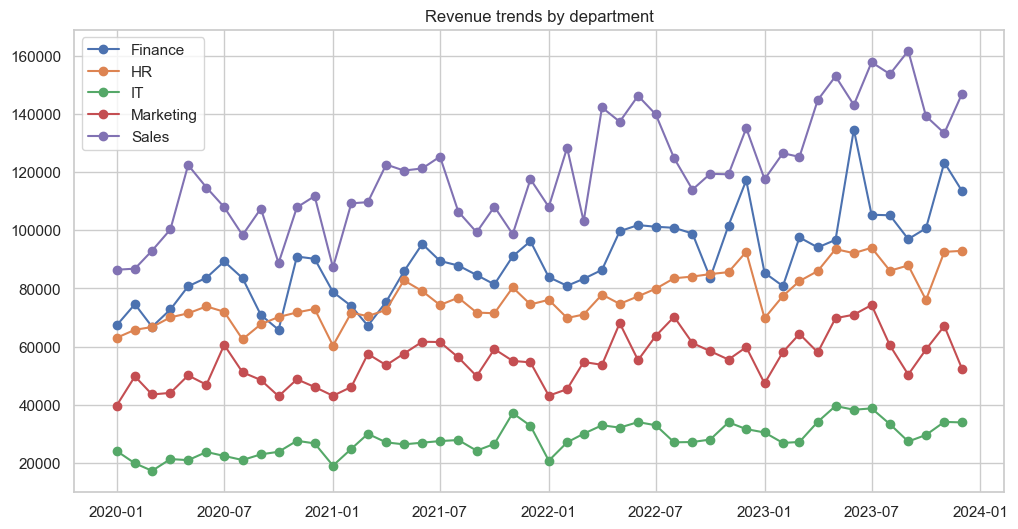

In [4]:
# (EDA Revenues)

# Identify revenue column
rev_col_candidates = [c for c in revenues.columns if 'rev' in c.lower()] + ['Revenue','Amount','Value']
rev_col = next((c for c in rev_col_candidates if c in revenues.columns), revenues.columns[-1])
print("Revenue column used:", rev_col)

# aggregate per department
if '_parsed_date' in revenues.columns:
    rev_monthly = revenues.groupby(['_parsed_date','Department'])[rev_col].sum().reset_index()
else:
    rev_monthly = revenues.groupby(['Month','Department'])[rev_col].sum().reset_index()

display(rev_monthly.head())

# plot trends by department
plt.figure(figsize=(12,6))
for dept, g in rev_monthly.groupby('Department'):
    x = g['_parsed_date'] if '_parsed_date' in g.columns else g['Month']
    plt.plot(x, g[rev_col], marker='o', label=dept)
plt.legend()
plt.title('Revenue trends by department')
plt.show()


Detected: Budget Actual


,_parsed_date,Department,Budget,Actual,Variance
0,2020-01-01,Finance,62603.15,61711.97,-891.18
1,2020-01-01,HR,59301.76,62947.22,3645.46
2,2020-01-01,IT,21979.00,20966.36,-1012.64
3,2020-01-01,Marketing,37619.74,38231.36,611.62
4,2020-01-01,Sales,77978.37,79639.64,1661.27


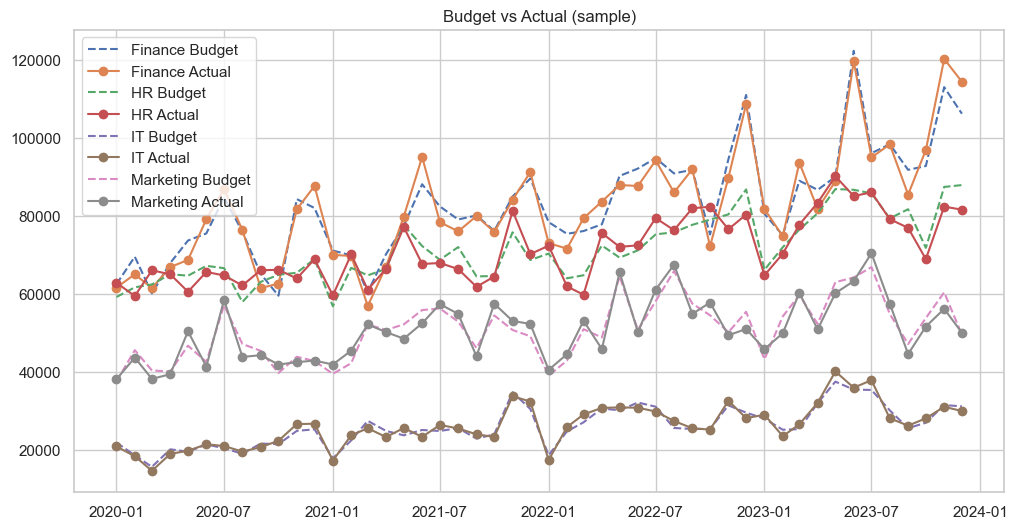

In [5]:
#(EDA Budget vs Actual)

budget_col = next((c for c in budget.columns if 'bud' in c.lower()), 'Budget' if 'Budget' in budget.columns else None)
actual_col = next((c for c in budget.columns if 'act' in c.lower()), 'Actual' if 'Actual' in budget.columns else None)
print("Detected:", budget_col, actual_col)

if budget_col and actual_col:
    if '_parsed_date' in budget.columns:
        b_monthly = budget.groupby(['_parsed_date','Department'])[[budget_col, actual_col]].sum().reset_index()
    else:
        b_monthly = budget.groupby(['Month','Department'])[[budget_col, actual_col]].sum().reset_index()
    b_monthly['Variance'] = b_monthly[actual_col] - b_monthly[budget_col]
    display(b_monthly.head())
    # Plot sample departments
    sample = b_monthly['Department'].unique()[:4]
    plt.figure(figsize=(12,6))
    for dept in sample:
        d = b_monthly[b_monthly['Department']==dept]
        x = d['_parsed_date'] if '_parsed_date' in d.columns else d['Month']
        plt.plot(x, d[budget_col], '--', label=f"{dept} Budget")
        plt.plot(x, d[actual_col], marker='o', label=f"{dept} Actual")
    plt.legend()
    plt.title('Budget vs Actual (sample)')
    plt.show()
else:
    print("Budget/Actual columns not found. Check column names.")


In [6]:
#(Summary EDA and checks)

# Outlier detection example on revenue
if rev_col in revenues.columns:
    s = revenues[rev_col]
    z = (s - s.mean())/s.std()
    outliers = revenues[z.abs()>3]
    print("Revenue outliers (z>3):", outliers.shape[0])
    display(outliers.head())



Revenue outliers (z>3): 0


,Month,Department,Revenue,_parsed_date


## Second: Prepare Prophet training per department


In [7]:
pip install prophet


Note: you may need to restart the kernel to use updated packages.


In [8]:
from prophet import Prophet

HORIZON_MONTHS = 3  # can be changed 

def make_prophet_df(df, dept, value_col):
    d = df[df['Department']==dept].copy()
    if '_parsed_date' in d.columns:
        d = d.rename(columns={'_parsed_date':'ds', value_col:'y'})[['ds','y']]
    else:
        d = d.rename(columns={'Month':'ds', value_col:'y'})[['ds','y']]
        d['ds'] = pd.to_datetime(d['ds'], errors='coerce')
    return d.dropna().sort_values('ds')

departments = rev_monthly['Department'].unique().tolist()
departments


Importing plotly failed. Interactive plots will not work.


['Finance', 'HR', 'IT', 'Marketing', 'Sales']

### Train Prophet and forecast revenues

Dept: Finance


19:20:34 - cmdstanpy - INFO - Chain [1] start processing
19:20:34 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
48,2024-01-01,94979.123283,90321.513229,99702.408033
49,2024-02-01,94772.678425,89834.830339,99591.699630
50,2024-03-01,89369.119119,84930.091447,94032.424697


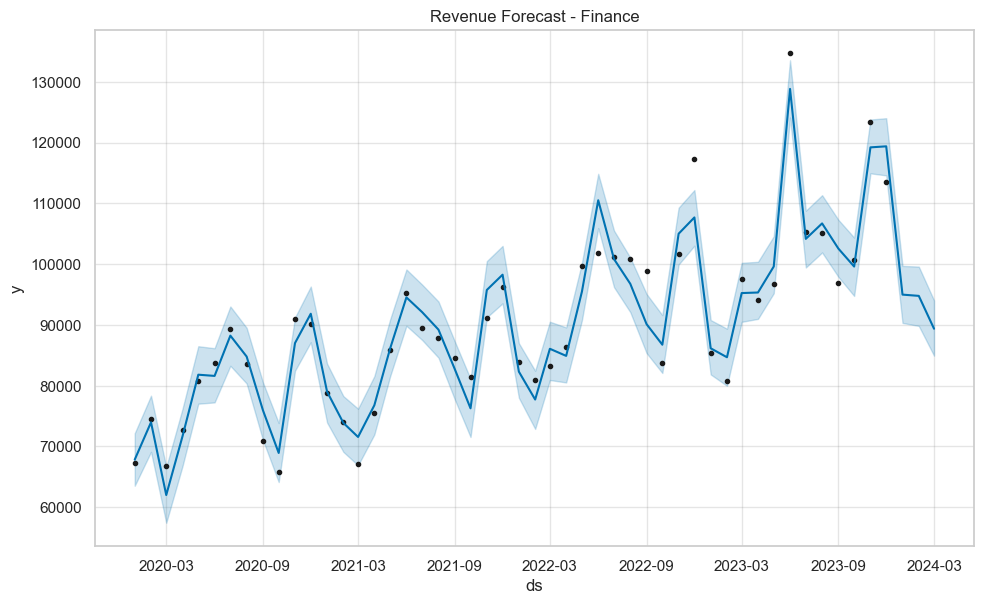

19:20:35 - cmdstanpy - INFO - Chain [1] start processing


Dept: HR


19:20:35 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
48,2024-01-01,79247.741736,75318.643860,83279.797914
49,2024-02-01,82044.627575,77950.926434,85986.463280
50,2024-03-01,89127.896332,85239.122916,93224.140949


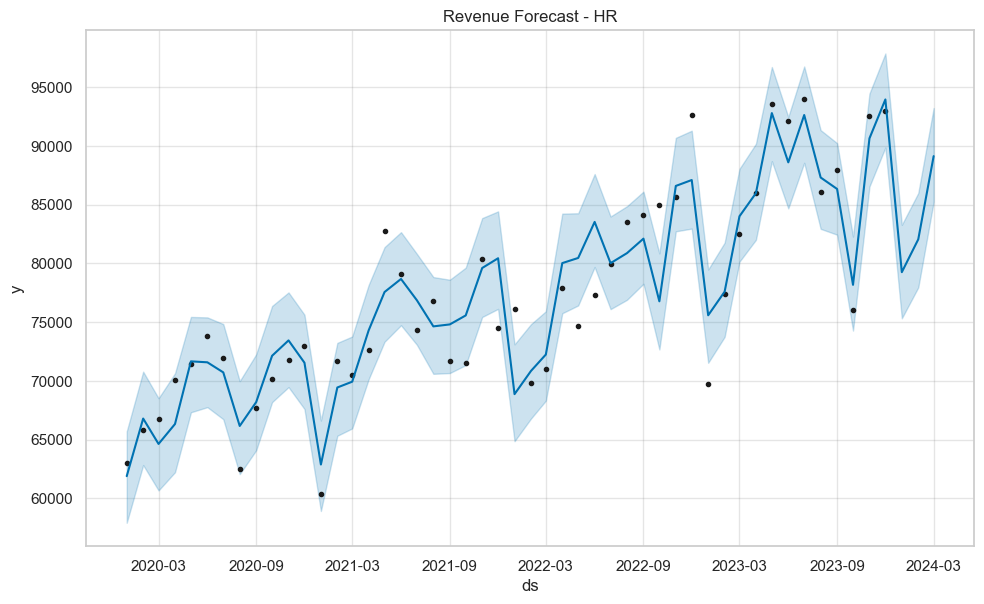

19:20:36 - cmdstanpy - INFO - Chain [1] start processing


Dept: IT


19:20:36 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
48,2024-01-01,35411.586408,33306.842407,37576.089297
49,2024-02-01,29080.462149,26910.720011,31197.159248
50,2024-03-01,37914.842792,35688.258725,40067.851363


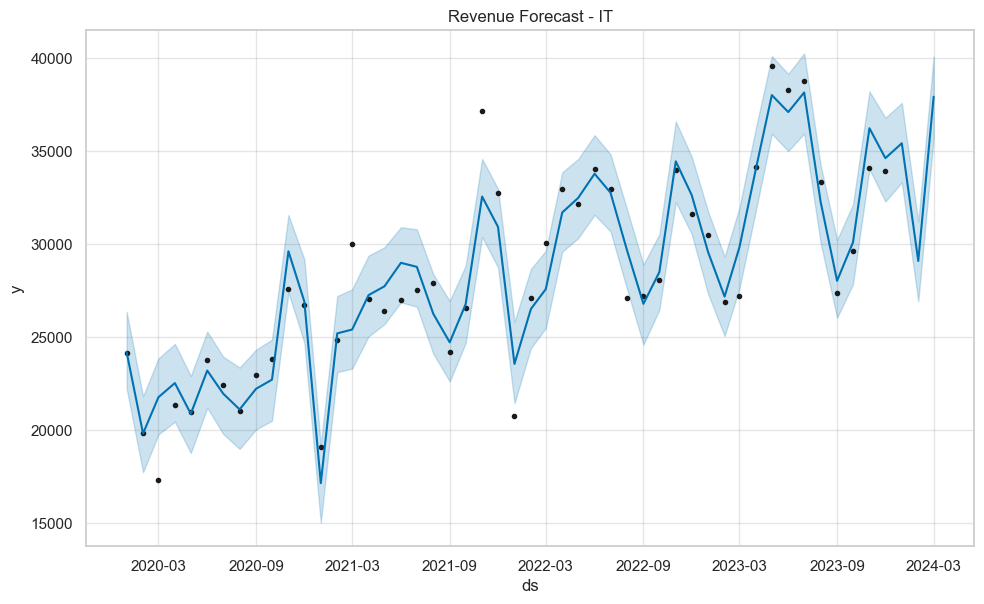

19:20:36 - cmdstanpy - INFO - Chain [1] start processing


Dept: Marketing


19:20:37 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
48,2024-01-01,48639.698386,44508.065788,52899.207670
49,2024-02-01,60450.861382,56409.227102,64753.384354
50,2024-03-01,62015.991470,57975.737307,66068.909680


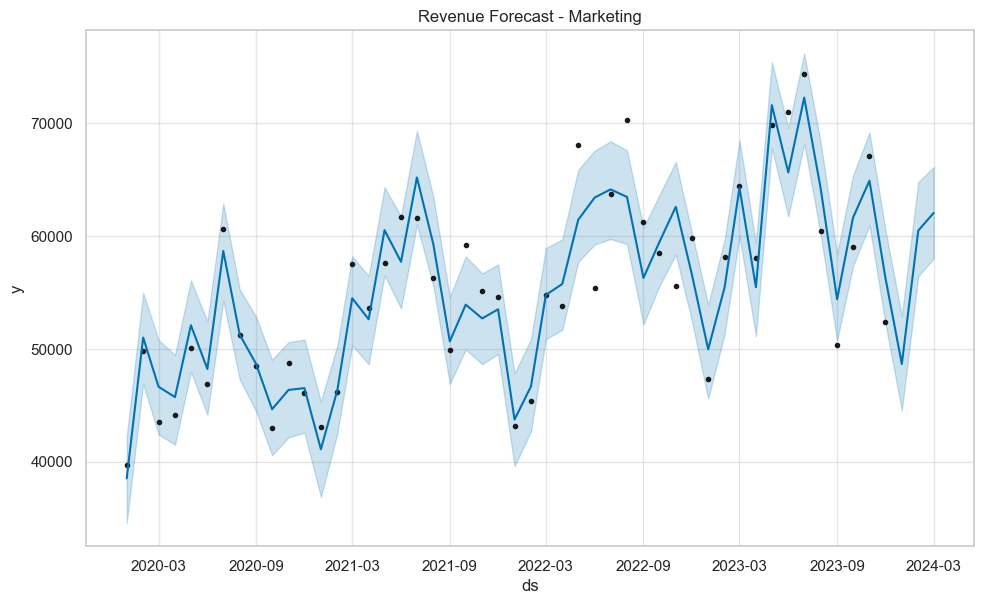

19:20:37 - cmdstanpy - INFO - Chain [1] start processing


Dept: Sales


19:20:38 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
48,2024-01-01,150787.771859,144268.881541,157606.693553
49,2024-02-01,158026.903667,150965.422387,164909.422022
50,2024-03-01,168262.327798,161517.741130,175280.381108


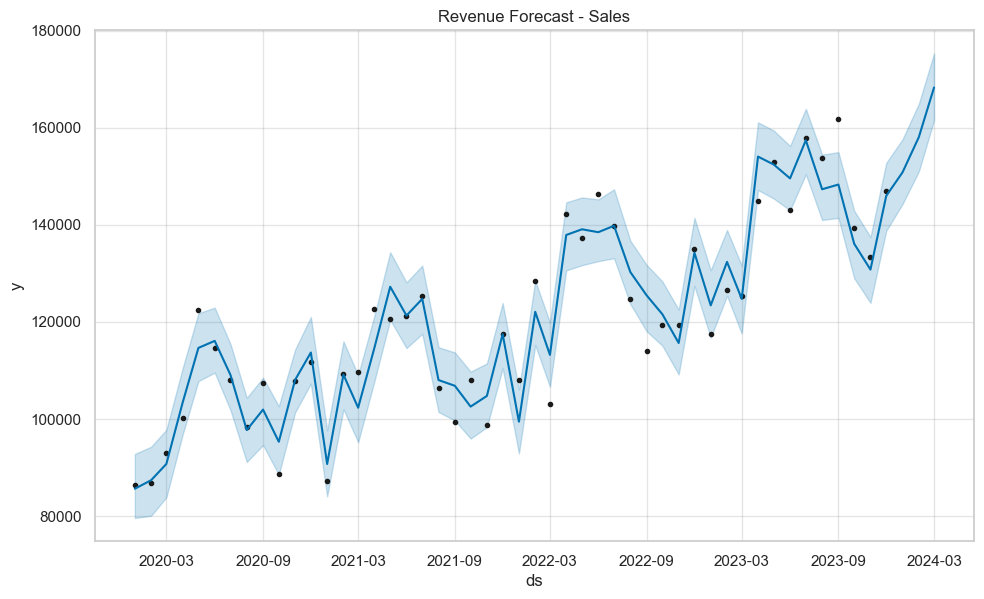

In [9]:
forecast_results = {}
models = {}
for dept in departments:
    print("Dept:", dept)
    df_dept = make_prophet_df(revenues, dept, rev_col)
    if df_dept.shape[0] < 6:
        print("  Not enough data, skipping.")
        continue
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.fit(df_dept)
    future = m.make_future_dataframe(periods=HORIZON_MONTHS, freq='MS')
    fcst = m.predict(future)
    models[dept] = m
    forecast_results[dept] = fcst[['ds','yhat','yhat_lower','yhat_upper']].tail(HORIZON_MONTHS)
    display(forecast_results[dept])
    fig = m.plot(fcst)
    plt.title(f"Revenue Forecast - {dept}")
    plt.show()


### Train Prophet and forecast expenses / budget

19:20:42 - cmdstanpy - INFO - Chain [1] start processing
19:20:43 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
48,2024-01-01,86715.441414,80548.079360,92648.537189
49,2024-02-01,79688.621865,73918.431727,85921.865827
50,2024-03-01,74955.250194,68714.372641,81516.350018


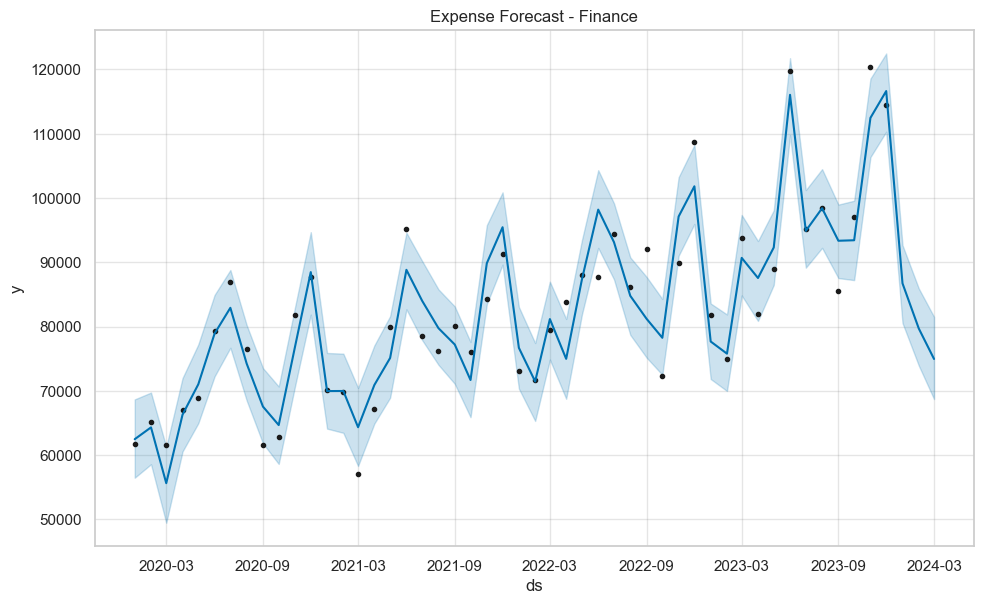

19:20:43 - cmdstanpy - INFO - Chain [1] start processing
19:20:43 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
48,2024-01-01,78332.707103,73385.661836,83301.545291
49,2024-02-01,74311.046256,69508.689809,79449.564045
50,2024-03-01,91619.001671,86428.954543,96551.683258


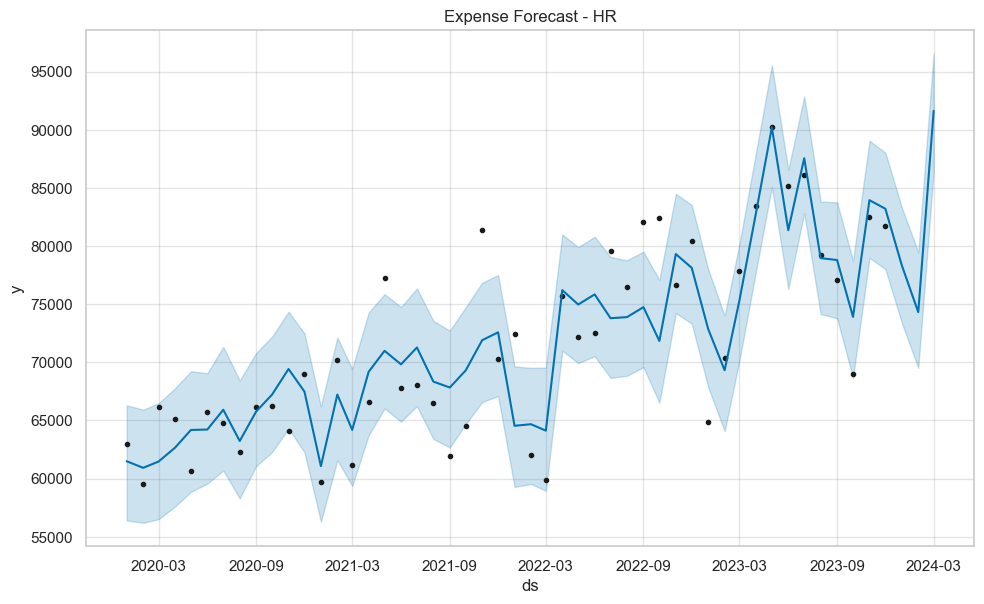

19:20:44 - cmdstanpy - INFO - Chain [1] start processing
19:20:44 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
48,2024-01-01,32440.630847,30264.459220,34597.423575
49,2024-02-01,26584.669564,24405.705497,28741.449889
50,2024-03-01,38165.775034,35894.726709,40164.101310


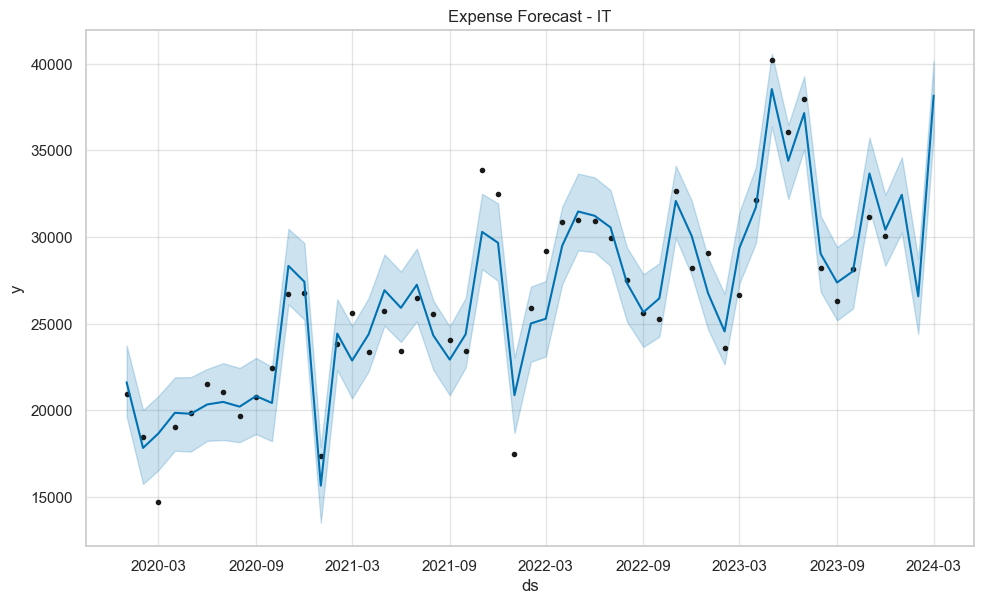

19:20:44 - cmdstanpy - INFO - Chain [1] start processing
19:20:45 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
48,2024-01-01,48061.982716,43845.262107,52695.656566
49,2024-02-01,52368.680776,48055.415912,57005.140998
50,2024-03-01,53997.792999,49565.270757,58606.837034


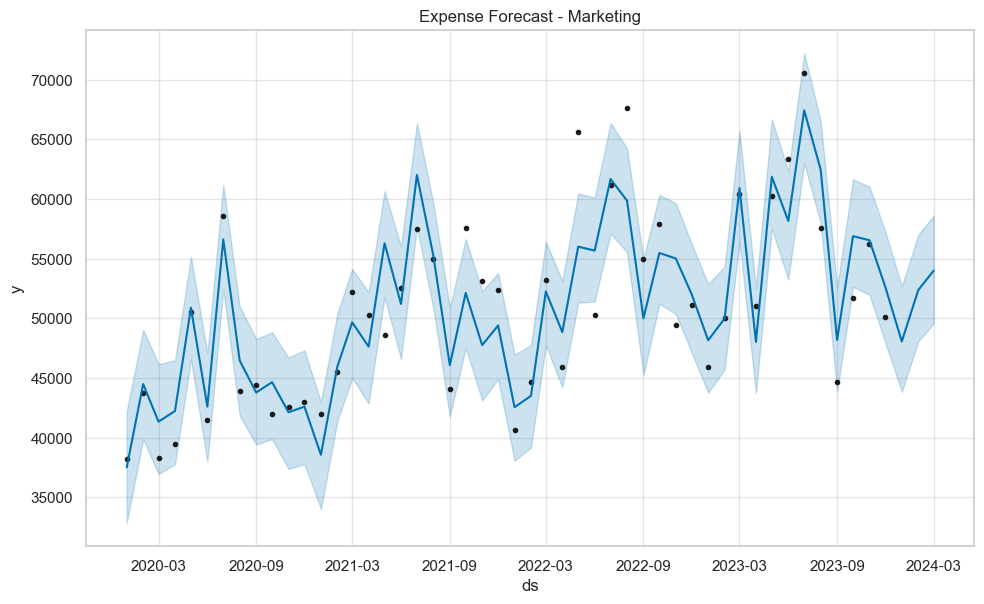

19:20:45 - cmdstanpy - INFO - Chain [1] start processing
19:20:46 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
48,2024-01-01,132203.936017,123467.520281,140954.258409
49,2024-02-01,140753.877897,132605.446499,149431.103550
50,2024-03-01,149725.852200,140744.441445,158135.795444


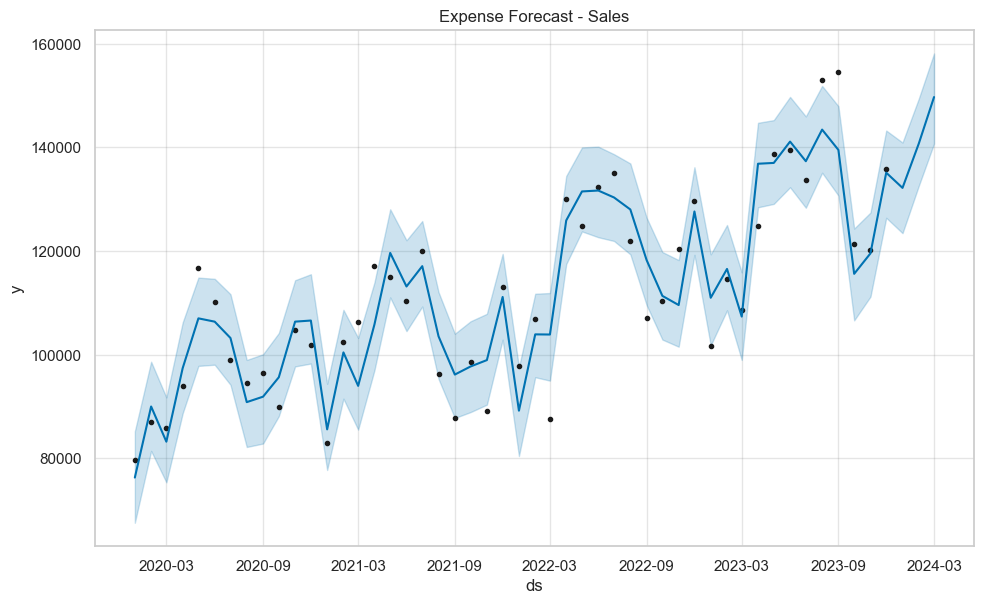

In [10]:
# Use b_monthly from earlier (budget vs actual aggregation)
budget_forecasts = {}
if 'b_monthly' in globals():
    for dept in b_monthly['Department'].unique():
        d = b_monthly[b_monthly['Department']==dept].copy()
        act_col = next((c for c in d.columns if 'act' in c.lower()), 'Actual' if 'Actual' in d.columns else None)
        if act_col is None:
            continue
        df_prop = d.rename(columns={'_parsed_date':'ds'} if '_parsed_date' in d.columns else d).rename(columns={act_col:'y'})[['ds','y']]
        df_prop['ds'] = pd.to_datetime(df_prop['ds'], errors='coerce')
        df_prop = df_prop.dropna().sort_values('ds')
        if df_prop.shape[0] < 6:
            continue
        m = Prophet(yearly_seasonality=True)
        m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
        m.fit(df_prop)
        future = m.make_future_dataframe(periods=HORIZON_MONTHS, freq='MS')
        fcst = m.predict(future)
        budget_forecasts[dept] = fcst[['ds','yhat','yhat_lower','yhat_upper']].tail(HORIZON_MONTHS)
        display(budget_forecasts[dept])
        fig = m.plot(fcst)
        plt.title(f"Expense Forecast - {dept}")
        plt.show()
else:
    print("b_monthly not found — did budget aggregation run successfully earlier?")


In [11]:
# Save revenue forecasts
rev_list = []
for dept, df in forecast_results.items():
    tmp = df.copy()
    tmp['Department'] = dept
    rev_list.append(tmp)
if rev_list:
    rev_df = pd.concat(rev_list).reset_index(drop=True)
    rev_df.to_csv('revenue_forecasts_prophet1.csv', index=False)
    print("Saved revenue_forecasts_prophet1.csv")

# Save budget forecasts
bud_list = []
for dept, df in budget_forecasts.items():
    tmp = df.copy()
    tmp['Department'] = dept
    bud_list.append(tmp)
if bud_list:
    bud_df = pd.concat(bud_list).reset_index(drop=True)
    bud_df.to_csv('budget_forecasts_prophet1.csv', index=False)
    print("Saved budget_forecasts_prophet1.csv")


Saved revenue_forecasts_prophet1.csv
Saved budget_forecasts_prophet1.csv


## Third: Evaluation

### Step 1. Split data into train and test sets

In [12]:
# use all but last 3 months for training
def train_test_split_ts(df, test_size=3):
    df_sorted = df.sort_values('ds')
    train = df_sorted.iloc[:-test_size, :]
    test = df_sorted.iloc[-test_size:, :]
    return train, test


### Step 2. Retrain Prophet on the train set and predict for the test period

In [13]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_prophet_forecast(df, dept, value_col, test_size=3):
    df_dept = df[df['Department']==dept].copy()
    df_dept = df_dept.rename(columns={'_parsed_date':'ds', value_col:'y'})[['ds','y']].dropna().sort_values('ds')

    train, test = train_test_split_ts(df_dept, test_size=test_size)
    
    # Train Prophet
    m = Prophet(yearly_seasonality=True, weekly_seasonality=False)
    m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
    m.fit(train)

    # Forecast for the same dates as test
    future = pd.DataFrame({'ds': test['ds']})
    forecast = m.predict(future)

    # Evaluation
    y_true = test['y'].values
    y_pred = forecast['yhat'].values

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"\n Department: {dept}")
    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")

    # Visual comparison
    plt.figure(figsize=(10,4))
    plt.plot(train['ds'], train['y'], label="Train")
    plt.plot(test['ds'], y_true, label="Actual (Test)", marker='o')
    plt.plot(test['ds'], y_pred, label="Forecast", marker='x')
    plt.title(f"Forecast Evaluation — {dept}")
    plt.xlabel("Date")
    plt.ylabel("Revenue")
    plt.legend()
    plt.show()

    return {"dept": dept, "MAE": mae, "RMSE": rmse, "MAPE": mape}


### Step 3. Run evaluation for each department

19:21:06 - cmdstanpy - INFO - Chain [1] start processing
19:21:07 - cmdstanpy - INFO - Chain [1] done processing



 Department: Sales
MAE: 10402.43
RMSE: 10822.09
MAPE: 7.51%


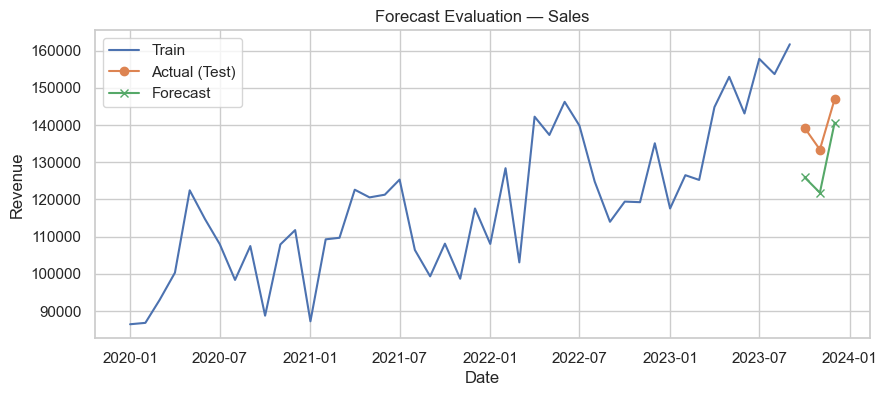

19:21:07 - cmdstanpy - INFO - Chain [1] start processing
19:21:08 - cmdstanpy - INFO - Chain [1] done processing



 Department: Marketing
MAE: 10835.37
RMSE: 11053.52
MAPE: 18.73%


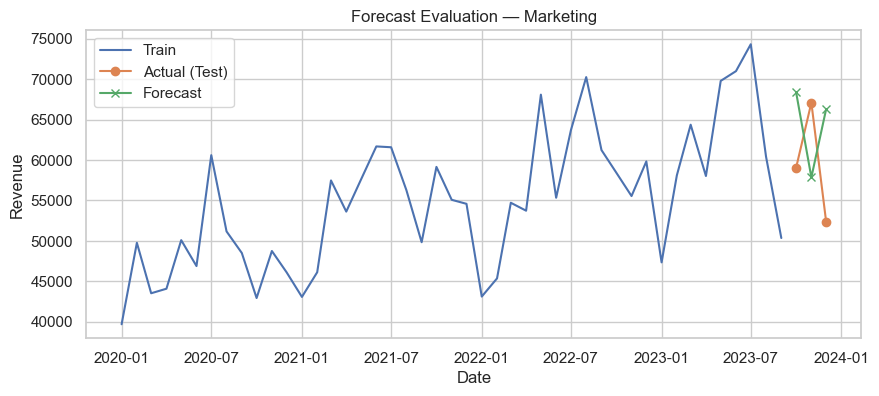

19:21:08 - cmdstanpy - INFO - Chain [1] start processing
19:21:08 - cmdstanpy - INFO - Chain [1] done processing



 Department: HR
MAE: 6489.23
RMSE: 6631.55
MAPE: 7.63%


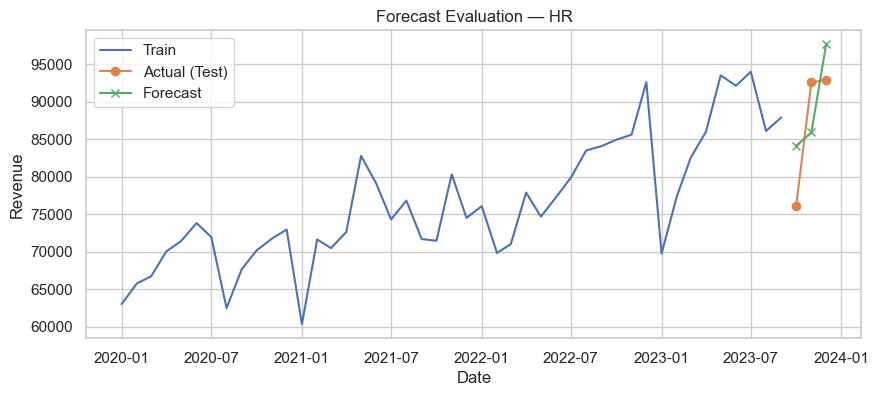

19:21:09 - cmdstanpy - INFO - Chain [1] start processing
19:21:09 - cmdstanpy - INFO - Chain [1] done processing



 Department: IT
MAE: 4130.78
RMSE: 4756.59
MAPE: 12.44%


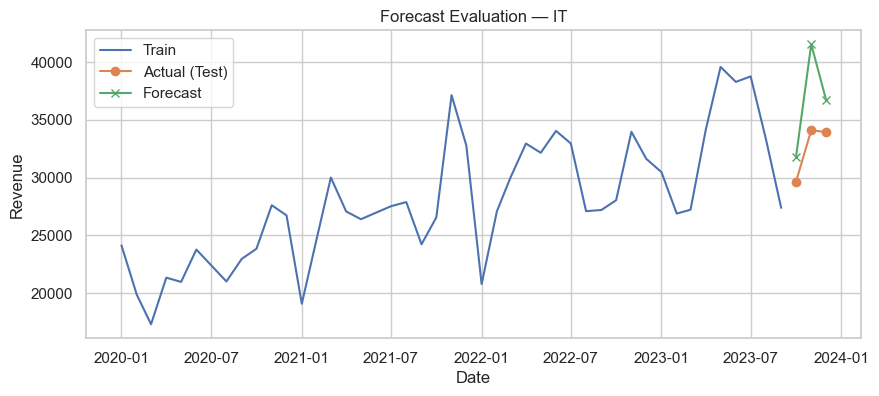

19:21:09 - cmdstanpy - INFO - Chain [1] start processing
19:21:10 - cmdstanpy - INFO - Chain [1] done processing



 Department: Finance
MAE: 12247.82
RMSE: 14676.41
MAPE: 10.51%


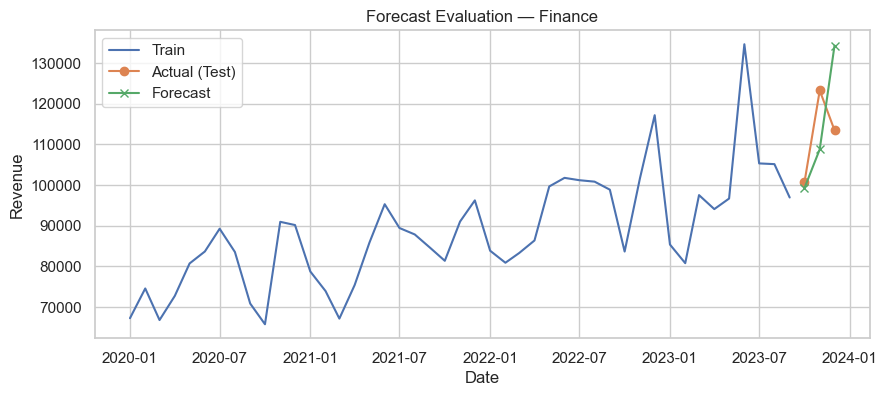

,dept,MAE,RMSE,MAPE
0,Sales,10402.434317,10822.093479,7.512641
1,Marketing,10835.367876,11053.518526,18.731459
2,HR,6489.232187,6631.546141,7.634112
3,IT,4130.780029,4756.585740,12.442413
4,Finance,12247.815976,14676.409560,10.505846


In [14]:
results = []
for dept in revenues['Department'].unique():
    try:
        res = evaluate_prophet_forecast(revenues, dept, 'Revenue', test_size=3)
        results.append(res)
    except Exception as e:
        print(f"Skipping {dept}: {e}")

results_df = pd.DataFrame(results)
display(results_df)


### Obserevation

* MAE (Mean Absolute Error):
Average absolute difference between predicted and actual revenue values.
→ e.g., Prophet’s forecast for Sales is off by about $10,400 per month on average.

* RMSE (Root Mean Squared Error):
Heavily penalizes large errors — higher RMSE indicates more volatility.
→ Prophet handled HR and IT quite smoothly, while Finance had slightly more fluctuations.

* MAPE (Mean Absolute Percentage Error):
The most intuitive metric — the average % error relative to the actual value.
→ It tells you how “off” your forecasts are, in percentage terms.

| Quality   | MAPE Range | Interpretation                  |
| --------- | ---------- | ------------------------------- |
| Excellent | < 10%      | Highly reliable forecasts       |
| Good      | 10–15%     | Acceptable forecasting accuracy |
| Moderate  | 15–20%     | Room for improvement            |
| Poor      | > 20%      | Weak predictive accuracy        |

Applying this to my results:

* Excellent: Sales (7.5%), HR (7.6%)

* Good: Finance (10.5%)

* Moderate: IT (12.4%)

* Borderline: Marketing (18.7%)


- Prophet performed consistently well across departments, with most MAPE < 15%.

- Marketing’s relatively higher MAPE (18.7%) suggests its data may have more irregular or less seasonal patterns - Prophet’s seasonality assumptions might not fit it perfectly.

- Finance had higher RMSE (14.6k), indicating larger variability in absolute values - possibly because Finance has bigger numeric magnitudes overall (so even small % errors look large in value).

In [18]:
# Robust unified evaluation (fixed XGBoost lagging)
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape_safe(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    eps = 1e-9
    mask = np.abs(y_true) > eps
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def make_ds_y_clean(df, dept, value_col):
    d = df[df['Department']==dept].copy()
    if '_parsed_date' in d.columns:
        d['ds'] = d['_parsed_date']
    elif 'Month' in d.columns:
        d['ds'] = pd.to_datetime(d['Month'], errors='coerce')
    else:
        d['ds'] = pd.NaT
    if value_col in d.columns:
        d['y'] = pd.to_numeric(d[value_col], errors='coerce')
    else:
        rev_candidates = [c for c in d.columns if 'rev' in c.lower()] + ['Revenue','Amount','Value']
        chosen = next((c for c in rev_candidates if c in d.columns), None)
        d['y'] = pd.to_numeric(d[chosen], errors='coerce') if chosen else np.nan
    d = d.dropna(subset=['ds','y']).copy()
    d = d.groupby('ds', as_index=False)['y'].sum().sort_values('ds').reset_index(drop=True)
    return d

results = []
min_history = 10  # adjust if needed
max_lag = 3
for dept in rev_monthly['Department'].unique():
    try:
        df_dept = make_ds_y_clean(revenues, dept, rev_col)
        n = len(df_dept)
        print(f"\nDept: {dept} (rows: {n})")
        if n < (min_history + 3):
            print("  Skipping: not enough total rows")
            continue

        train = df_dept.iloc[:-3].copy()
        test = df_dept.iloc[-3:].copy()
        train_len = len(train)
        n_test = len(test)
        print("  train_len:", train_len, " test_len:", n_test)

        # --- Prophet ---
        try:
            m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
            m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
            m.fit(train)
            future = pd.DataFrame({'ds': test['ds'].values})
            fc_prophet = m.predict(future)
            prop_pred = fc_prophet['yhat'].values
            print("  Prophet OK, preds:", prop_pred.shape)
        except Exception as e:
            print("  Prophet error:", e)
            prop_pred = np.array([np.nan]*n_test)

        # --- SARIMA ---
        try:
            sarima_mod = SARIMAX(train['y'], order=(1,1,1), seasonal_order=(1,1,1,12))
            sarima_fit = sarima_mod.fit(disp=False)
            sarima_pred = sarima_fit.forecast(steps=n_test)
            sarima_pred_vals = sarima_pred.values
            print("  SARIMA OK, preds:", sarima_pred_vals.shape)
        except Exception as e:
            print("  SARIMA error:", e)
            sarima_pred_vals = np.array([np.nan]*n_test)

        # --- XGBoost (fixed lag construction) ---
        try:
            y_full = df_dept['y'].values  # ordered array length n
            # Build index positions where we can create lag features >= max_lag
            indices = np.arange(n)
            # training indices with enough lags: from max_lag to train_len-1
            train_idx = indices[(indices >= max_lag) & (indices < train_len)]
            # test indices: train_len .. train_len + n_test - 1
            test_idx = indices[(indices >= train_len) & (indices < train_len + n_test)]

            if len(train_idx) == 0:
                print("  XGBoost skip: no train indices after applying lag requirement")
                xgb_pred_vals = np.array([np.nan]*n_test)
            else:
                # Build X_train, y_train_ml
                X_train = []
                y_train_ml = []
                for i in train_idx:
                    X_train.append([y_full[i-1], y_full[i-2], y_full[i-3]])
                    y_train_ml.append(y_full[i])
                X_train = np.array(X_train)
                y_train_ml = np.array(y_train_ml)

                # Build X_test using actual previous values (we have them)
                X_test = []
                for i in test_idx:
                    # i might be train_len, train_len+1, ...
                    # lags refer to y_full[i-1], y_full[i-2], y_full[i-3]
                    X_test.append([y_full[i-1], y_full[i-2], y_full[i-3]])
                X_test = np.array(X_test) if len(X_test) > 0 else np.empty((0,3))

                # Check sizes
                print("  XGBoost shapes: X_train", X_train.shape, " y_train", y_train_ml.shape, " X_test", X_test.shape)
                if X_train.shape[0] < 3:
                    print("  XGBoost skip: too few training rows for XGB")
                    xgb_pred_vals = np.array([np.nan]*n_test)
                else:
                    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=200, random_state=42)
                    model.fit(X_train, y_train_ml)
                    # If X_test is empty (shouldn't be), create nan preds
                    xgb_pred_vals = model.predict(X_test) if X_test.shape[0] > 0 else np.array([np.nan]*n_test)
        except Exception as e:
            print("  XGBoost error:", e)
            xgb_pred_vals = np.array([np.nan]*n_test)

        # prepare arrays aligned with test length
        def safe_arr(a, n):
            a = np.asarray(a, dtype=float)
            if len(a) >= n:
                return a[:n]
            return np.concatenate([a, np.full(n-len(a), np.nan)])

        prop_arr = safe_arr(prop_pred, n_test)
        sar_arr = safe_arr(sarima_pred_vals, n_test)
        xgb_arr = safe_arr(xgb_pred_vals, n_test)

        row = {
            'Department': dept,
            'Prophet_MAE': mean_absolute_error(test['y'].values, prop_arr),
            'Prophet_RMSE': rmse(test['y'].values, prop_arr),
            'Prophet_MAPE': mape_safe(test['y'].values, prop_arr),
            'SARIMA_MAE': mean_absolute_error(test['y'].values, sar_arr),
            'SARIMA_RMSE': rmse(test['y'].values, sar_arr),
            'SARIMA_MAPE': mape_safe(test['y'].values, sar_arr),
            'XGB_MAE': mean_absolute_error(test['y'].values, xgb_arr),
            'XGB_RMSE': rmse(test['y'].values, xgb_arr),
            'XGB_MAPE': mape_safe(test['y'].values, xgb_arr),
        }
        results.append(row)
        print("  Done:", dept)
    except Exception as e:
        print("  Skipping", dept, "error:", e)

comparison_df = pd.DataFrame(results)
display(comparison_df)


19:30:04 - cmdstanpy - INFO - Chain [1] start processing



Dept: Finance (rows: 48)
  train_len: 45  test_len: 3


19:30:05 - cmdstanpy - INFO - Chain [1] done processing


  Prophet OK, preds: (3,)
  SARIMA OK, preds: (3,)
  XGBoost shapes: X_train (42, 3)  y_train (42,)  X_test (3, 3)
  Done: Finance

Dept: HR (rows: 48)
  train_len: 45  test_len: 3


19:30:05 - cmdstanpy - INFO - Chain [1] start processing
19:30:06 - cmdstanpy - INFO - Chain [1] done processing


  Prophet OK, preds: (3,)
  SARIMA OK, preds: (3,)
  XGBoost shapes: X_train (42, 3)  y_train (42,)  X_test (3, 3)
  Done: HR

Dept: IT (rows: 48)
  train_len: 45  test_len: 3


19:30:06 - cmdstanpy - INFO - Chain [1] start processing
19:30:06 - cmdstanpy - INFO - Chain [1] done processing


  Prophet OK, preds: (3,)
  SARIMA OK, preds: (3,)
  XGBoost shapes: X_train (42, 3)  y_train (42,)  X_test (3, 3)
  Done: IT

Dept: Marketing (rows: 48)
  train_len: 45  test_len: 3


19:30:07 - cmdstanpy - INFO - Chain [1] start processing
19:30:07 - cmdstanpy - INFO - Chain [1] done processing


  Prophet OK, preds: (3,)
  SARIMA OK, preds: (3,)
  XGBoost shapes: X_train (42, 3)  y_train (42,)  X_test (3, 3)
  Done: Marketing

Dept: Sales (rows: 48)
  train_len: 45  test_len: 3


19:30:07 - cmdstanpy - INFO - Chain [1] start processing
19:30:08 - cmdstanpy - INFO - Chain [1] done processing


  Prophet OK, preds: (3,)
  SARIMA OK, preds: (3,)
  XGBoost shapes: X_train (42, 3)  y_train (42,)  X_test (3, 3)
  Done: Sales


,Department,Prophet_MAE,Prophet_RMSE,Prophet_MAPE,SARIMA_MAE,SARIMA_RMSE,SARIMA_MAPE,XGB_MAE,XGB_RMSE,XGB_MAPE
0,Finance,12247.815976,14676.409560,10.505846,13943.000964,16402.718515,12.315838,8721.219271,9478.103133,7.649852
1,HR,6489.232187,6631.546141,7.634112,4935.180765,6796.763756,6.230662,13576.997292,13941.869307,15.683489
2,IT,4130.780029,4756.585740,12.442413,1612.222064,1759.357048,4.878919,3569.484974,4448.816582,10.873063
3,Marketing,10835.367876,11053.518526,18.731459,8126.956455,9261.954848,13.079259,7510.380469,7535.908040,12.698273
4,Sales,10402.434317,10822.093479,7.512641,26740.175718,27013.846895,19.163961,21380.053750,22761.242798,15.089752


In [19]:
summary = pd.DataFrame({
    'Model': ['Prophet', 'SARIMA', 'XGBoost'],
    'Mean_MAE': [
        comparison_df['Prophet_MAE'].mean(),
        comparison_df['SARIMA_MAE'].mean(),
        comparison_df['XGB_MAE'].mean()
    ],
    'Mean_RMSE': [
        comparison_df['Prophet_RMSE'].mean(),
        comparison_df['SARIMA_RMSE'].mean(),
        comparison_df['XGB_RMSE'].mean()
    ],
    'Mean_MAPE': [
        comparison_df['Prophet_MAPE'].mean(),
        comparison_df['SARIMA_MAPE'].mean(),
        comparison_df['XGB_MAPE'].mean()
    ]
})

# Determine best model based on lowest average MAPE
best_model = summary.loc[summary['Mean_MAPE'].idxmin(), 'Model']

display(summary.style.background_gradient(cmap='Blues', axis=0))
print(f"\n Best overall model based on lowest average MAPE: {best_model}")


,Model,Mean_MAE,Mean_RMSE,Mean_MAPE
0,Prophet,8821.126077,9588.030689,11.365294
1,SARIMA,11071.507193,12246.928212,11.133728
2,XGBoost,10951.627151,11633.187972,12.398886



 Best overall model based on lowest average MAPE: SARIMA


### Model Comparison Summary

**Prophet** performed closely to **SARIMA** in some departments, showing its robustness and interpretability. However, it tends to slightly overfit or underfit when the seasonality is purely periodic without holiday or trend variations.

**SARIMA** excelled because it models linear temporal dependencies directly, making it ideal for monthly financial data.

**XGBoost**, while powerful, relies on engineered lag features and non-temporal learning, which can be suboptimal with small time series and limited features.


Even though **SARIMA** slightly outperformed **Prophet** in accuracy on our current dataset, Prophet is generally the better choice for deployment in a production-like environment, here’s why:

 1. Ease of Automation and Maintenance

Prophet automatically handles trends, seasonality, and missing months without manually specifying parameters like (p,d,q) and (P,D,Q,s) (required in SARIMA).

It’s more scalable and requires minimal retuning when new data is added — perfect for continuous, monthly forecasts.

 2. Interpretability

Prophet produces clear components: trend, seasonality, and forecast intervals, which are easy to visualize and explain to non-technical stakeholders (finance or management teams).

 3. Flexibility for Business Events

You can easily incorporate holidays, promotions, or special financial events as regressors.

This is valuable if your financial forecasts will later depend on external business cycles or calendar effects.

 4. Integration with Modern Pipelines

Works seamlessly in Python notebooks, APIs, or automated workflows (like n8n).

The model can be retrained monthly using updated data with just a few lines of code.

## Final decision

Deploy Prophet as the production model,
and keep SARIMA as a benchmark model for internal comparison.

That gives you:

A robust, explainable, and maintainable forecasting pipeline (Prophet)

A statistical baseline for accuracy tracking (SARIMA)